<a href="https://colab.research.google.com/github/vqrca/bootcamp_alura_aulas/blob/main/Modulo_5/M%C3%B3dulo_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste módulo as aulas abordaram os seguintes temas:

- Workflow em projetos de Data Science;
- Matriz de confusão;
- Precision, Recall, F1, curva ROC e AUC;
- Desafios na Validação de modelo;
- Aplicação da Validação cruzada.

##**Aula 1 - Workflow de Machine Learning**

Machine learning nos ajuda a escalar tarefas em que os humanos são bons:

- Reconhecimentos de imagens
- Análise de sentimentos
- Reconhecimento de caracteres

e também tarefas em que os humanos NÃO são bons:

- Detecção de deepfake
- Limites de crédito
- Detecção de fraudes
- Previsões de faturamento

**PASSOS NO WORKFLOW EM MACHINE LEARNING:**

- 1 - Definição do objetivo e impacto no negócio. 

> Qual é o nosso problema e qual é o impacto na resolução do problema?

- 2 - Aquisição de transformação dos dados.

> É necessário unir os dados e entender o que faz sentido para nós. 

- 3 - Desenvolvimento do modelo.

> Essa etapa envolve a análise exploratória 

- 4 - Comunicação dos resultados

- 5 - Deploy e monitoramento







In [3]:
import pandas as pd
import numpy as np

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [5]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [6]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [7]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes 
#tornando a coluna AGE_PERCENTIL em categórica para que a idade seja considerada no modelo
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [8]:
dados_limpos['AGE_PERCENTIL']

PATIENT_VISIT_IDENTIFIER      
0                         0       5
2                         10      0
3                         15      3
4                         20      0
5                         25      0
                                 ..
380                       1900    3
381                       1905    9
382                       1910    4
383                       1915    3
384                       1920    4
Name: AGE_PERCENTIL, Length: 352, dtype: int8

In [9]:
dados_limpos.shape

(352, 231)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)

#Modelo: DummyClassifier

x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1) #essa coluna pode ser retirada pois todos os pacientes estão dentro dessa janela
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
#Modelo LogisticRegression
modelo = LogisticRegression(max_iter=10000) #Aumentar o número de iterações da regressão logística para convergir.
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

##**Aula 2 - Métricas de Avaliação**

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

Acurácia é tudo o que acertamos.
Para plotar os valores preditos pelos valores reais:

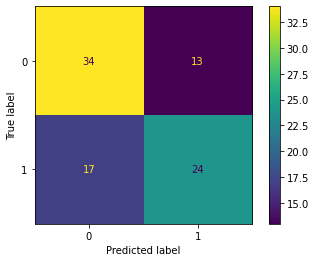

In [13]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

No eixo Y temos os valores verdadeiros

No eixo X temos os valores preditos

Portanto, quando a pessoa vai para UTI (1), o modelo errou 17 vezes e acertou 24 vezes.

Porém, é muito importante acertar em relação às pessoas que vão precisar de UTI. Seria muito ruim dar alta para alguém e essa pessoa fosse para casa e tivesse que voltar novamente.

A acurácia sozinha não mostrava isso para nós, pois ela nos mostra só a diagonal desse gráfico (34 e 24).

Temos siglas importantes na matriz de confusão:

- VP = verdadeiro positivo (label=1 e predição=1)

- VN = verdadeiro negativo (quando a pessoa não precisa ir para UTI: label=0 e predição=0)

- FP = falso positivo (label=0 e predição=1)

- FN = falso negativo (label=1 e predição=1)







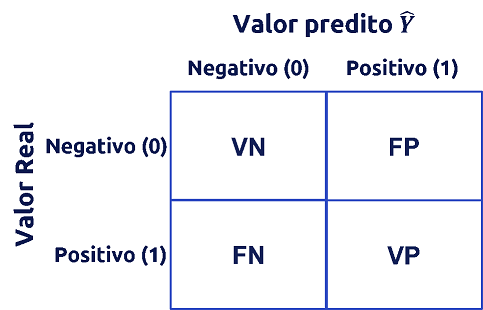

Cálculo de métricas com base na matriz de confusão:

In [ ]:
VP = 24
VN = 34
FP = 13
FN = 17

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



- **Precision:** mostra quantos positivos (VP e FP) estão corretos, para ter certeza do que estamos acertando. É ótima para ser analisada quando o falso positivo é pior que o falso negativo. 




In [ ]:
#Precisao = todas as minhas classificacoes positivas, quantas são realmente positivas 
#Recall = todas as classes positivas, quantas eu realmente classifiquei corretamente

precision = VP/(VP+FP)
precision

0.6486486486486487

Pelo F1 é possível ver se a precisão ou recall estão muito baixos. Isso é calculado através da média harmônica. 

> Média harmônica é a quantidade de elementos no conjunto, divida pela soma do inverso dos elementos do conjunto

In [ ]:
#cálculo do F1
p = 0.67 #p: precision
r = 0.72 #r: recall
f1 = 2* (p * r)/(p + r)  
print(f1)

0.6941007194244604


Métrica AUC - Calcula a área sob uma curva e consegue separar as pessoas que precisam de UTI das pessoas que não precisam de UTI. 
Quando mais próximo da ponta da diagonal: melhor é o resultado. Há uma separação das classes .
Quem tiver AUC maior tem a melhor medida 

In [ ]:
from sklearn.metrics import roc_auc_score

prob_arvore = modelo_arvore.predict_proba(x_test) #retorna a probalidade de estar classificando o x de teste
roc_auc_score(y_test, prob_arvore[:,1]) #[:,1] pegar todas as linhas e a coluna 1 que é a probalidade da classe ser igual a 1
#y score: probabilidade da classe ser positiva 

0.6543850544888428

Função criada para rodar os modelos:

In [ ]:
def roda_modelo(modelo, dados):

    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    predicao = modelo.predict(x_test)
    prob_predic = modelo.predict_proba(x_test)

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    print("\nClassification Report")
    print(classification_report(y_test, predicao))

In [ ]:
roda_modelo(modelo_arvore, dados_limpos)  #modelo de árvore de decisão

AUC 0.6193565127140633

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



In [ ]:
roda_modelo(modelo, dados_limpos) #modelo de regressão

AUC 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



A cada vez que rodamos os modelos os resultados são diferentes devido a aleatoriedade. Portanto, precisamos garantir que esses efeitos sejam minimizados.

##**Aula 3 - Aleatoriedade de Modelos**

Função para diminuir a aleatoriedade:

In [ ]:
def roda_n_modelos(modelo, dados, n):

    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    auc_lista = [] #lista para add valores de AUC
    for _ in range(n): #para fazer a separação de treino e teste n vezes. Usamos o _ pois os valores criados na iteração não serão usados
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

        modelo.fit(x_train, y_train)
        prob_predic = modelo.predict_proba(x_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc) #para não printar todo AUC toda vez que rodar a iteração, então os valores serão add em uma lista
    
    auc_medio = np.mean(auc_lista) #média dos valores de AUC
    auc_std = np.std(auc_lista) #desvio padrão dos valores de AUC
    print(f"AUC {auc_medio}") #retorna média dos valores de AUC
    print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}") #retorna o intervalo onde 95% dos dados estão 

Testando os modelos de árvore de decisão e regressão logística:

In [ ]:
roda_n_modelos(modelo_arvore, dados_limpos,50) #Testando árvore de decisão - rodar 50x

AUC 0.6309289050337312
Intervalo 0.5351693321456963 - 0.7266884779217662


In [ ]:
roda_n_modelos(modelo, dados_limpos,50) #Testando a regressão logística - rodar 50x

AUC 0.7520913336792943
Intervalo 0.6724738789165902 - 0.8317087884419984


##**Aula 4 - Validação Cruzada**

A princípio nós estávamos separando os dados para Treino e Teste. Quando fazemos isso o efeito de aleatoriedade é muito grande.Então, a escolha do algoritmo passa a ter um nível de incerteza um pouco maior. Portanto, criamos a função `roda_n_modelos`, mas isso não garante que todos os dados foram treinados e testados.Então, vamos tentar fazer a divisão dos dados de uma forma mais estratégica, utilizando o Cross-Validation.
Usando essa abordagem o conjunto de dados é divido em várias partes. A cada momento uma parte desses dados será utilizada como teste e o restante como treino, garantindo que todos os dados sejam testados e treinados:


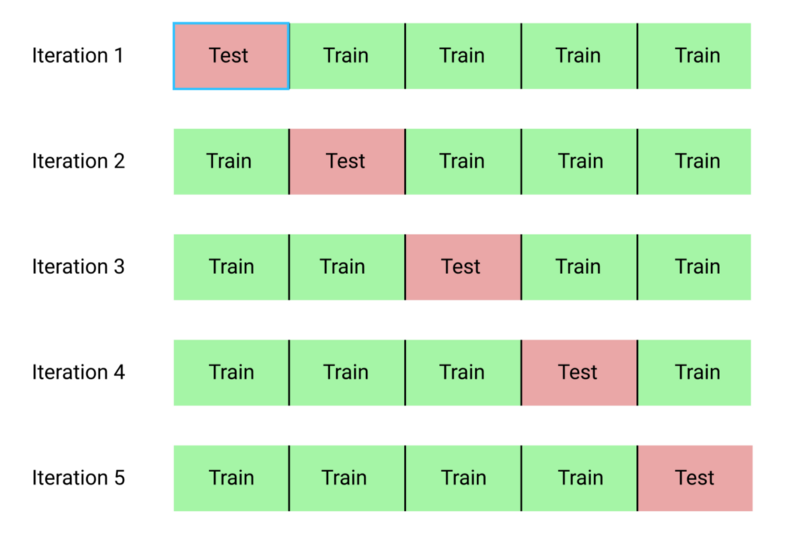

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold #para fazer o split dos dados

cv = StratifiedKFold(n_splits = 5, shuffle = True) #número de splits, shuffle faz o embaralhamento dos dados
"""Esse parâmetro é muito importante quando os dados estão desbalanceados, pois podemos
ter proporções diferentes entre uma classe e outra"""
cross_validate(modelo, x, y, cv=cv) # x=dados limpos, y=ICU, cv=cv - quantas divisões serão feitas

{'fit_time': array([0.20526314, 0.57905746, 0.59178305, 0.51906943, 0.26107073]),
 'score_time': array([0.0022366 , 0.00229955, 0.0022316 , 0.00224686, 0.00221634]),
 'test_score': array([0.70422535, 0.74647887, 0.71428571, 0.65714286, 0.74285714])}

Como temos poucos dados, precisamos ter mais certeza dos nossos resultados. Podemos fazer isso adicionando `n_repeats`: 

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10) #Repetindo 10 vezes as cinco divisões
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.32140183, 0.22037816, 0.1980412 , 0.67307854, 0.19617748,
        0.64931774, 0.1817317 , 0.28041196, 0.27977896, 0.59529591,
        0.52863264, 0.25111604, 0.26257396, 0.24158216, 0.55959797,
        0.6111691 , 0.51960945, 0.5634346 , 0.2170763 , 0.50759315,
        0.61491108, 0.56451368, 0.48918438, 0.29671288, 0.61443233,
        0.80947804, 0.64515686, 0.56661272, 0.60261178, 0.69225788,
        0.26959634, 0.18498588, 0.21672916, 0.65467691, 0.52202654,
        0.57137561, 0.16967201, 0.23191476, 0.56760025, 0.22607851,
        0.35341716, 0.64471865, 0.60217166, 0.55837584, 0.56485677,
        0.1974473 , 0.56375456, 0.52488589, 0.62316656, 0.60224843]),
 'score_time': array([0.00224924, 0.00226021, 0.00223112, 0.00224566, 0.00536036,
        0.00224996, 0.00232148, 0.00227046, 0.00223684, 0.00232148,
        0.00228119, 0.00226092, 0.00224042, 0.00229001, 0.00225925,
        0.00222683, 0.00226712, 0.00223684, 0.00223923, 0.00229406,
        0.00226665, 

Nova função, incluindo isso:

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) #para garantir a reprodutibilidade
    dados = dados.sample(frac=1).reset_index(drop=True) #dados.sample(frac=1): embaralhamento dos dados
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score']) #media do AUC - teste
    auc_medio_treino = np.mean(resultados['train_score']) #media do AUC - treino

    auc_std = np.std(resultados['test_score']) #desvio-padrão do teste
    
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

Testando os dois modelos:

In [ ]:
#Árvore de decisão
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio 0.6279279683391525 Intervalo 0.4988394445682657 - 0.7570164921100394


In [ ]:
#Regressão logística
roda_modelo_cv(modelo, dados_limpos, 5, 10) #5 splits e 10 repetições

AUC Médio 0.7575511875511876 Intervalo 0.6366273412799195 - 0.8784750338224556


A regressão logística deu um resultado melhor!

##**Aula 5 - Desafios em Machine Learning**

Modificando os hiperparâmetros da árvore de decisão:

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino
    #print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

teste_lista = []
treino_lista = []
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth=i) #max_depth: profundidade máxima da árvore 
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC  0.5755830262080263 - 0.6445982993536308
AUC  0.6544700741411268 - 0.75415524801741
AUC  0.6643847795163584 - 0.8243714304989842
AUC  0.6554932930837536 - 0.8832038893699776
AUC  0.6475058192163456 - 0.9275331115338461
AUC  0.6239047951959137 - 0.9567921210944048
AUC  0.6117738776455882 - 0.9745102329260463
AUC  0.5987671815056683 - 0.9855938255169409
AUC  0.5877544694814432 - 0.991376822665679
AUC  0.5917582923832925 - 0.9946888385564852
AUC  0.6009579413444545 - 0.9970452758822465
AUC  0.6147261533363507 - 0.9986297665919551
AUC  0.6212348996723998 - 0.9994661199548005
AUC  0.6256292095025647 - 0.9998695491440995


Valor de AUC de teste - Valor de AUC de treino.

Quanto maior a profundidade o valor de AUC de teste cai e o de treino aumenta.


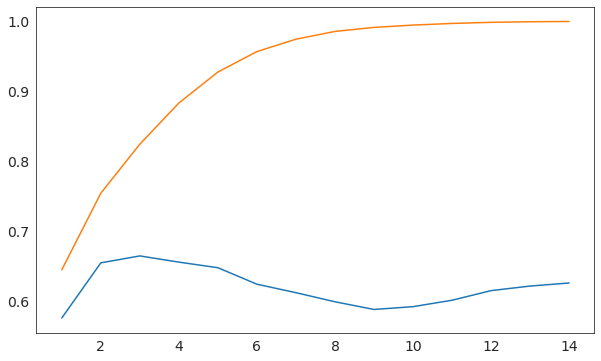

In [ ]:
import matplotlib.pyplot as plt

x = range(1,15)
plt.plot(x, teste_lista) 
plt.plot(x, treino_lista)

Em laranja temos as médias de AUC para treino.

Em azul temos as médias de AUC para teste.

Os valores começam relativamente próximos, porém após o quinto max depth, os dados de teste começam a cair. Enquanto isso, os valores de treino começam a crescer. Quando isso ocorre temos o *Overfitting*: o modelo ficou tão bom em separar os dados a partir do treino, que ele não consegue generalizar os dados de teste. 


###**Florestas aleatórias**

Um problema que encontramos na aplicação de algoritmos de árvores de decisão é o sobreajuste (overfit). Ou seja, a árvore se ajusta demais aos dados de treino. Isso é um problema na aplicação de algoritmos de machine learning porque o objetivo é que o modelo de machine learning não apenas memorize os dados que usou para aprender sobre o problema. O ideal é que o modelo seja capaz de generalizar o problema, conseguindo fazer predições corretas com base em dados que não foram utilizados no aprendizado.

**O algoritmo de floresta aleatória (random forest) é utilizado para tratar este problema de sobreajuste**. Este é um algoritmo de aprendizagem de conjunto.


**Algoritmos de aprendizagem de conjunto**

Algoritmos de aprendizagem de conjunto (ensemble) são algoritmos que combinam diversos algoritmos de machine learning em um modelo de predição. O objetivo é diminuir a variabilidade dos resultados, vieses e melhorar as predições. Um algoritmo de aprendizagem em conjunto pode utilizar qualquer algoritmo de machine learning como a regressão logística, árvores de decisão e etc. Assim, as predições feitas por cada algoritmo são utilizadas como entrada em um generalizador, o algoritmo de aprendizagem de conjunto.


**Como o algoritmo de floresta aleatória trabalha?**

O algoritmo de floresta aleatória é um algoritmo de aprendizagem de conjunto que utiliza árvores de decisão. Para fazer a previsão, o algoritmo cria árvores de decisão em amostras dos dados e obtém a predição de cada uma das árvores. Finalmente o algoritmo seleciona a melhor solução como sendo a solução de maior ocorrência. No exemplo da figura abaixo a saída adotada pelo algoritmo seria o diagnóstico de covid já que este é o que aparece mais vezes.


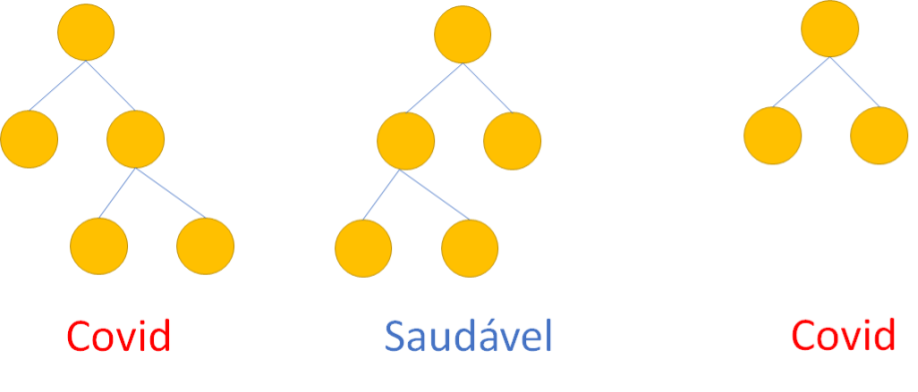

O termo “aleatória” da floresta aleatória surge porque para cada árvore é passada uma amostra aleatória dos dados de treino. Além disso, subconjuntos aleatórios de atributos são considerados na hora de dividir os nodos da árvore. Se os nossos dados de treinamento são uma lista igual [1,2,3,4,5,6], então podemos dar a uma de nossas árvores a lista [1,2,2,3,6,6] e podemos dar a outra árvore uma lista [2,3,4,4,5,6]. Ou seja, se estivéssemos trabalhando com dados de covid iríamos passar a mesma quantidade de pacientes de forma embaralhada. Repare que para manter o mesmo número de pacientes eventualmente são passados pacientes repetidos para uma mesma árvore.

In [ ]:
from sklearn.ensemble import RandomForestClassifier #várias árvores de decisão

teste_lista = []
treino_lista = []
for i in range(1,5):
    modelo_arvore = RandomForestClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC  0.7754785968683994 - 0.8549995635150238
AUC  0.7868632672744513 - 0.8976687127896622
AUC  0.7931550390103022 - 0.9403124842531797
AUC  0.7983565832578993 - 0.9709123570096604


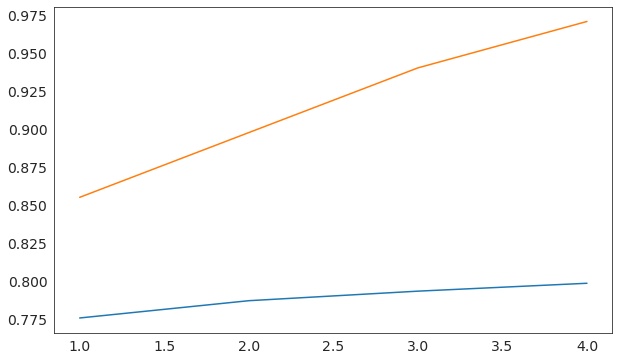

In [ ]:
import matplotlib.pyplot as plt

x = range(1,5)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

Adicionando outro hiperparâmetro `n_estimators`, que define quants árvores serão criadas:


In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7428159147484805 - 0.999444041300827


In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7939557739557739 - 1.0


In [ ]:

modelo_arvore = RandomForestClassifier(n_estimators=200)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7950421219664641 - 1.0


Com 100 e 200 não houve quase nenhuma alteração. Até então, o melhor modelo foi o RadomForest!

##**Aula 6 - Finalizando a validação**

Diminuir o número de labels pode ajudar a diminuir o Overfitting e a melhorar os resultados do nosso modelo:


In [ ]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


Técnica para remover features com alta correlação:

In [ ]:
dados_limpos.select_dtypes(exclude='float64') #excluindo float64

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


Essas são as colunas que não interessam na correlação.

In [ ]:
alta_corr = 0.95 #acima de 0.95 será considerado altamente correlacionado
matrix_corr = dados_limpos.iloc[:,4:-2].corr().abs() #abs: valores absolutos, deixa somente os positivos
excluir = [coluna for coluna in matrix_corr.columns if any(matrix_corr[coluna] > alta_corr)]
#função any: ela testa alguma expressão booleana e retorna se tem ou não algum valor (se é falso ou verdadeiro).

In [ ]:
matrix_corr

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,0.009174,0.009174,0.009174,0.009174,NaN,0.030413,0.030413,0.030413,0.030413,NaN,0.104179,0.104179,0.104179,0.104179,NaN,0.013215,0.013215,0.013215,0.013215,NaN,0.072771,0.072771,0.072771,0.072771,NaN,0.046671,0.046671,0.046671,0.046671,NaN,0.020510,...,0.005561,0.005561,0.005561,NaN,0.105965,0.112316,0.015686,0.089330,0.035513,0.025573,0.100418,0.110268,0.033409,0.092466,0.033773,0.031653,0.084358,0.124403,0.021311,0.094510,0.024580,0.037813,0.120437,0.099909,0.032427,0.073348,0.042184,0.008804,0.054710,0.053091,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,0.196347,1.000000,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,0.032245,0.032245,0.032245,0.032245,NaN,0.013532,0.013532,0.013532,0.013532,NaN,0.027544,0.027544,0.027544,0.027544,NaN,0.005880,0.005880,0.005880,0.005880,NaN,0.036119,0.036119,0.036119,0.036119,NaN,0.003539,0.003539,0.003539,0.003539,NaN,0.009126,...,0.048981,0.048981,0.048981,NaN,0.095532,0.031352,0.016813,0.020068,0.011225,0.032448,0.112696,0.024483,0.012664,0.021007,0.012416,0.059772,0.093647,0.026938,0.021756,0.019150,0.005121,0.038081,0.070772,0.041188,0.015483,0.018921,0.016164,0.006302,0.046677,0.029821,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,0.278271,0.084392,1.000000,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,0.035719,0.035719,0.035719,0.035719,NaN,0.028061,0.028061,0.028061,0.028061,NaN,0.078813,0.078813,0.078813,0.078813,NaN,0.121935,0.121935,0.121935,0.121935,NaN,0.058743,0.058743,0.058743,0.058743,NaN,0.006233,0.006233,0.006233,0.006233,NaN,0.165258,...,0.009263,0.009263,0.009263,NaN,0.046600,0.144381,0.050511,0.052495,0.095023,0.149534,0.055008,0.141602,0.047499,0.043561,0.093179,0.149762,0.039784,0.136814,0.048458,0.060394,0.093307,0.139419,0.044819,0.150604,0.053770,0.049369,0.088511,0.140484,0.005354,0.027667,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,0.017529,0.114818,0.308875,1.000000,0.128287,0.171438,0.136472,0.103100,0.063919,0.049593,0.049593,0.049593,0.049593,NaN,0.012640,0.012640,0.012640,0.012640,NaN,0.051789,0.051789,0.051789,0.051789,NaN,0.005492,0.005492,0.005492,0.005492,NaN,0.072546,0.072546,0.072546,0.072546,NaN,0.028718,0.028718,0.028718,0.028718,NaN,0.008524,...,0.033033,0.0

Checando quais colunas possuem alta correlação:

In [ ]:
excluir

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEDIAN',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEDIAN',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEDIAN',
 'GLUCOSE_MEAN',
 '

In [ ]:
len(excluir)

189

Se pararmos para pensar a diagonal da matriz é sempre 1. Portanto, tudo está sendo exlcuído, pois todas as colunas terão um valor = 1.
Vamos refazer os comandos, para que isso não aconteça:

In [ ]:
matrix_corr.shape #formato da matriz

(225, 225)

In [ ]:
#como desconsiderar a digonal=1:

matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)] #exclusão das colunas
excluir

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

`where` - troca os valores onde a condição for falsa

`np.ones` - criar uma matrix a partir de outra

`astype(np.bool))`- conversão para booleano


**Para eliminar diagonal principal e triângulo inferior:**

`np.triu` - elimina o triangulo

`k=1` - elimina a diagonal principal






Função para retirar os dados altamente correlacionados:

In [ ]:
def remove_corr_var(dados, valor_corte):

    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

    return dados.drop(excluir, axis=1)

dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95)

In [ ]:
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

Comparando o modelo de árvore de decisão com e sem as colunas altamente correlacionadas:

In [ ]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7950421219664641 - 1.0


(0.7950421219664641, 1.0)

In [ ]:
roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC  0.8042220502500108 - 1.0


(0.8042220502500108, 1.0)

Houve uma melhora muito pequena.

#**Desafios**

##**Aula 1**

###**Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método.** ✔️

In [ ]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [ ]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

####**Método 1 - Criação de dicionário e uso do `replace`:**

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
age = {'10th' : 0, '20th' : 1,'30th' : 2, '40th' : 3, '50th' : 4, '60th' : 5, '70th' : 6, '80th' : 7, '90th' : 8, 'Above 90th': 9}
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.replace(age)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [ ]:
dados_limpos['AGE_PERCENTIL']

PATIENT_VISIT_IDENTIFIER      
0                         0       5
2                         10      0
3                         15      3
4                         20      0
5                         25      0
                                 ..
380                       1900    3
381                       1905    9
382                       1910    4
383                       1915    3
384                       1920    4
Name: AGE_PERCENTIL, Length: 352, dtype: int64

####**Método 2 - Função LabelEncoder pelo sklearn:**

In [ ]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [ ]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
dados_limpos.AGE_PERCENTIL = le.fit_transform(dados_limpos.AGE_PERCENTIL)
dados_limpos.AGE_PERCENTIL

PATIENT_VISIT_IDENTIFIER      
0                         0       5
2                         10      0
3                         15      3
4                         20      0
5                         25      0
                                 ..
380                       1900    3
381                       1905    9
382                       1910    4
383                       1915    3
384                       1920    4
Name: AGE_PERCENTIL, Length: 352, dtype: int64

##**Aula 2**

###**Desafio 02: Verificar o impacto da mudança nos resultados.** ✔️

In [ ]:
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [ ]:
np.random.seed(73246)

#Modelo: DummyClassifier

x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1) #essa coluna pode ser retirada pois todos os pacientes estão dentro dessa janela
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
#Modelo LogisticRegression
modelo = LogisticRegression(max_iter=10000) #Aumentar o número de iterações da regressão logística para convergir.
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

Os resultados não foram alterados!

###**Desafio 03: Pesquisar sobre F-score.** ✔️

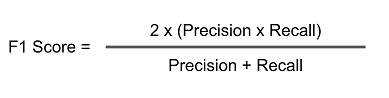

"Em análise estatística de classificação binária, o F1 score (também conhecido como F-score ou F-measure) é uma medida de acurácia de um teste. Ele leva em consideração tanto a precisão quanto a revocação do teste para computar o score […] O F-score é a média harmônica da precisão e da revocação, onde o F-score atinge seu valor máximo em 1 (perfeita precisão e revocação) e o mínimo em 0."

Referência:

> [Que tal avaliar seu modelo? — Parte 1](https://medium.com/data-hackers/que-tal-avaliar-seu-modelo-parte-1-66b24cbb8e7a)

###**Desafio 04: Pesquisar e plotar a arvore de decisão criada pelo modelo.** ✔️

In [ ]:
modelo_arvore = tree.DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6363636363636364

####**Método 1 - plot_tree**

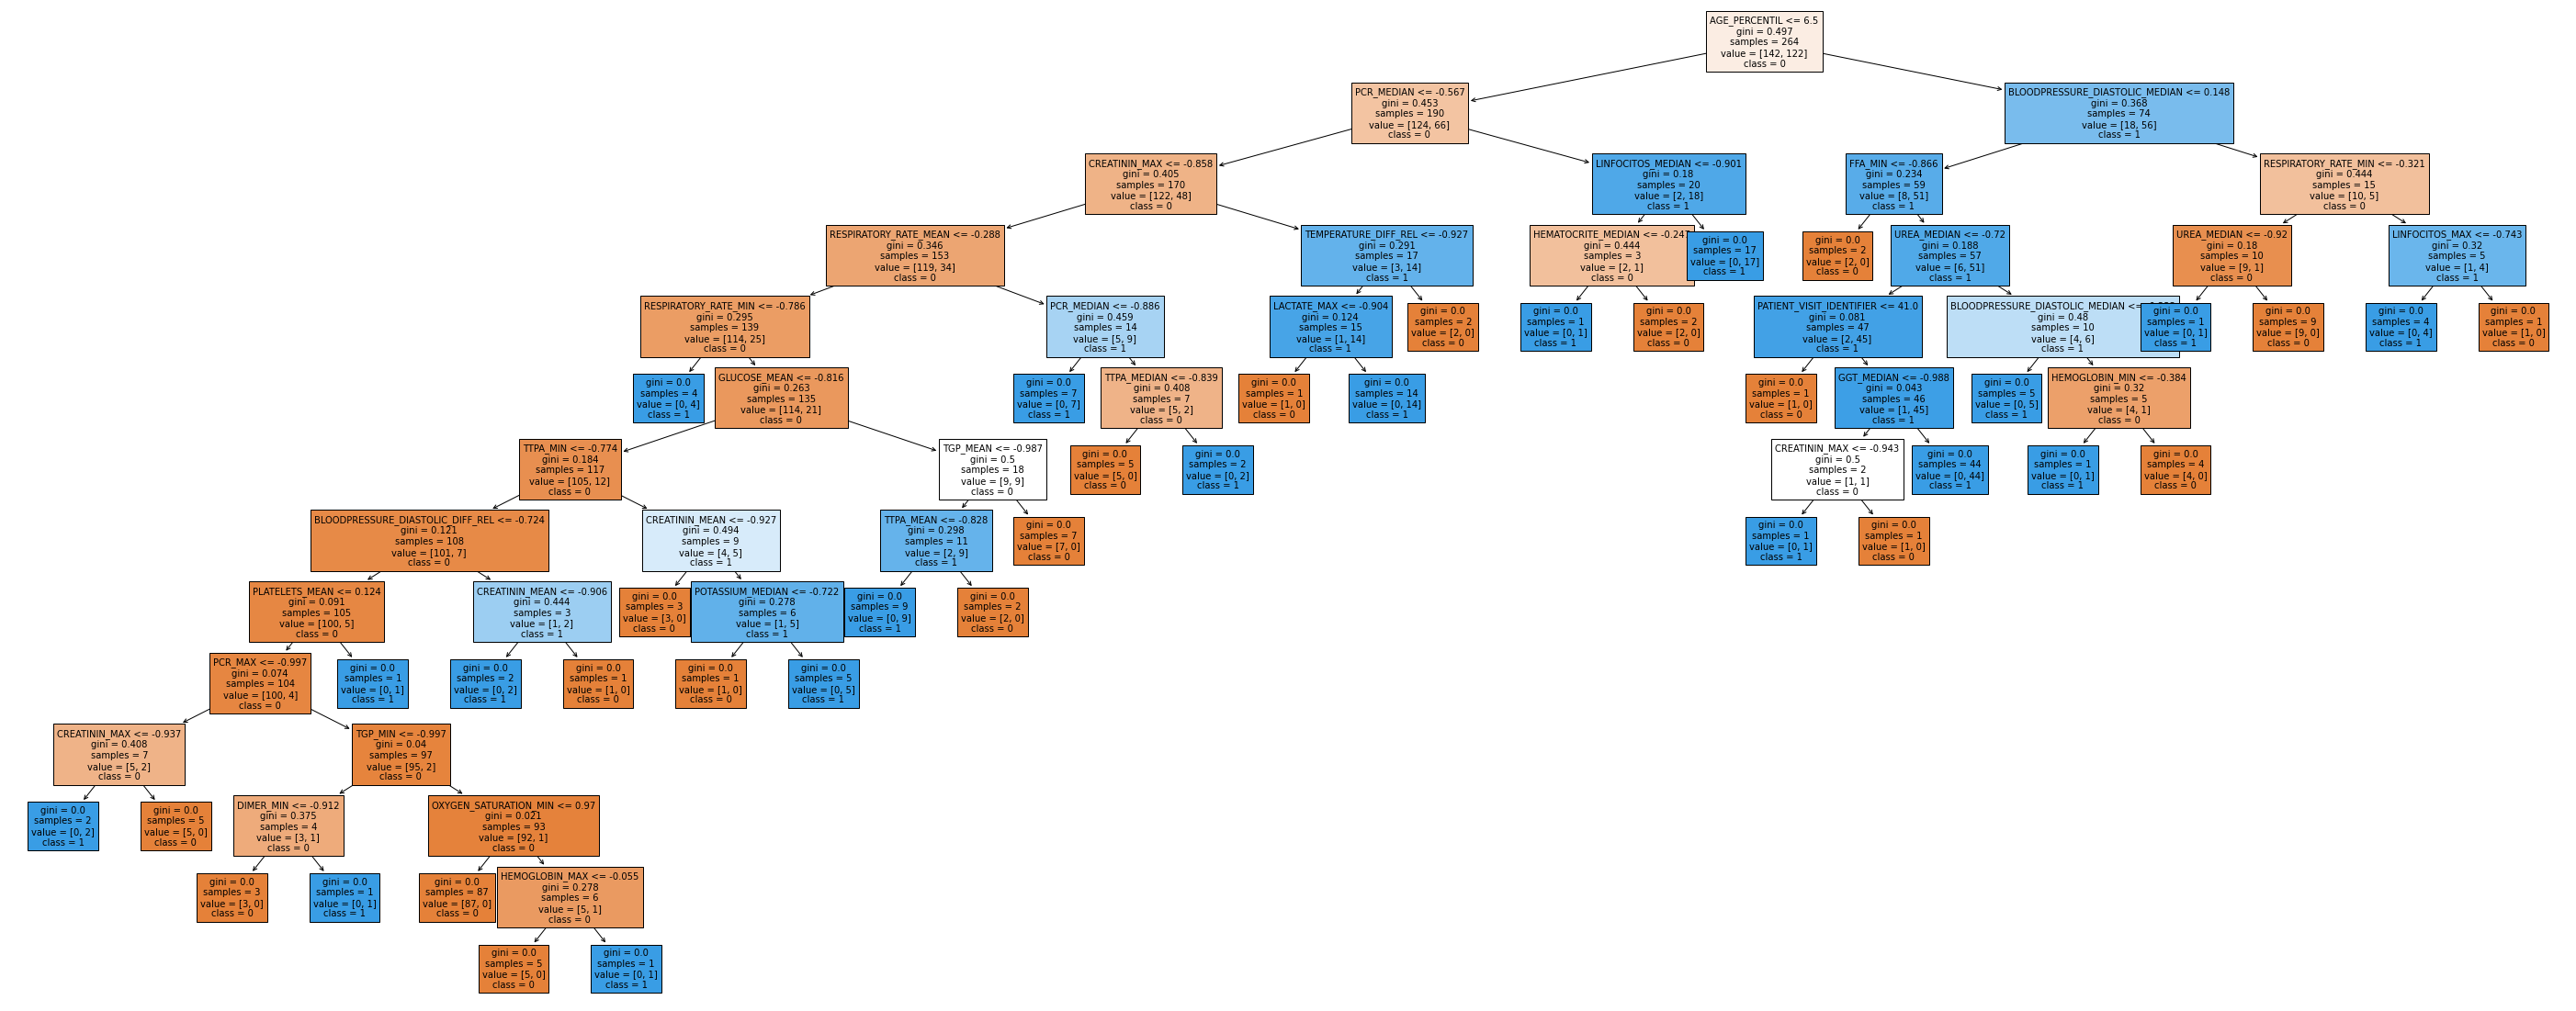

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize = (50,20))

plot_tree(modelo_arvore, feature_names=x.columns, class_names=['0','1'],fontsize= 10, filled=True)

plt.show()

####**Método 2 - Usando o graphviz:**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

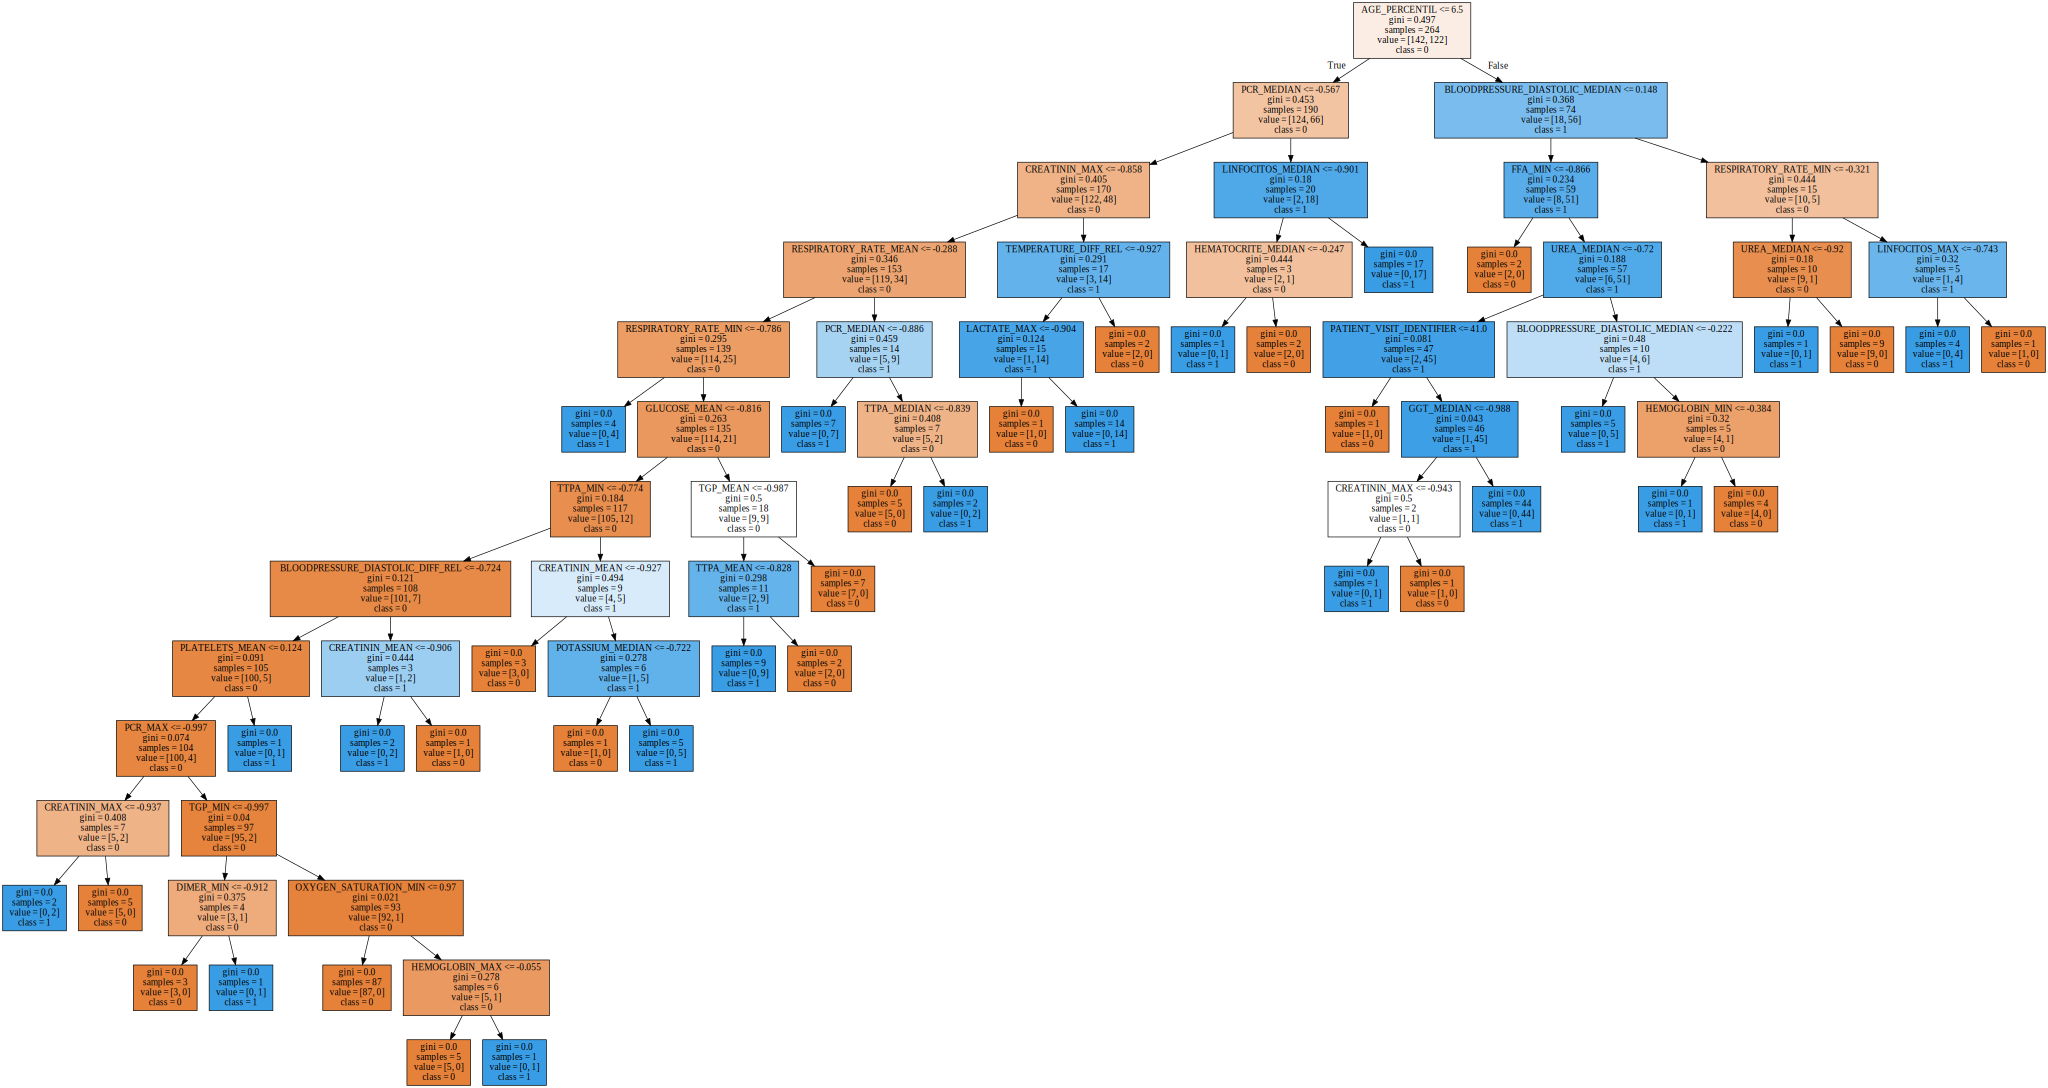

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, 
                           feature_names=x.columns,
                           class_names=['0','1'],
                           filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph



####**Método 3 - Usando o dtreeviz:**

In [ ]:
!pip install dtreeviz

     |████████████████████████████████| 60 kB 2.6 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66636 sha256=ce2122505815a72f29285debc241bdfd4a9e237323534c37b4ffe50c2e3ef548
  Stored in directory: /root/.cache/pip/wheels/9f/a6/a1/898c991294471015f13c1e5b456fb8134c1af835db4dd93a7a
Successfully built dtreeviz


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


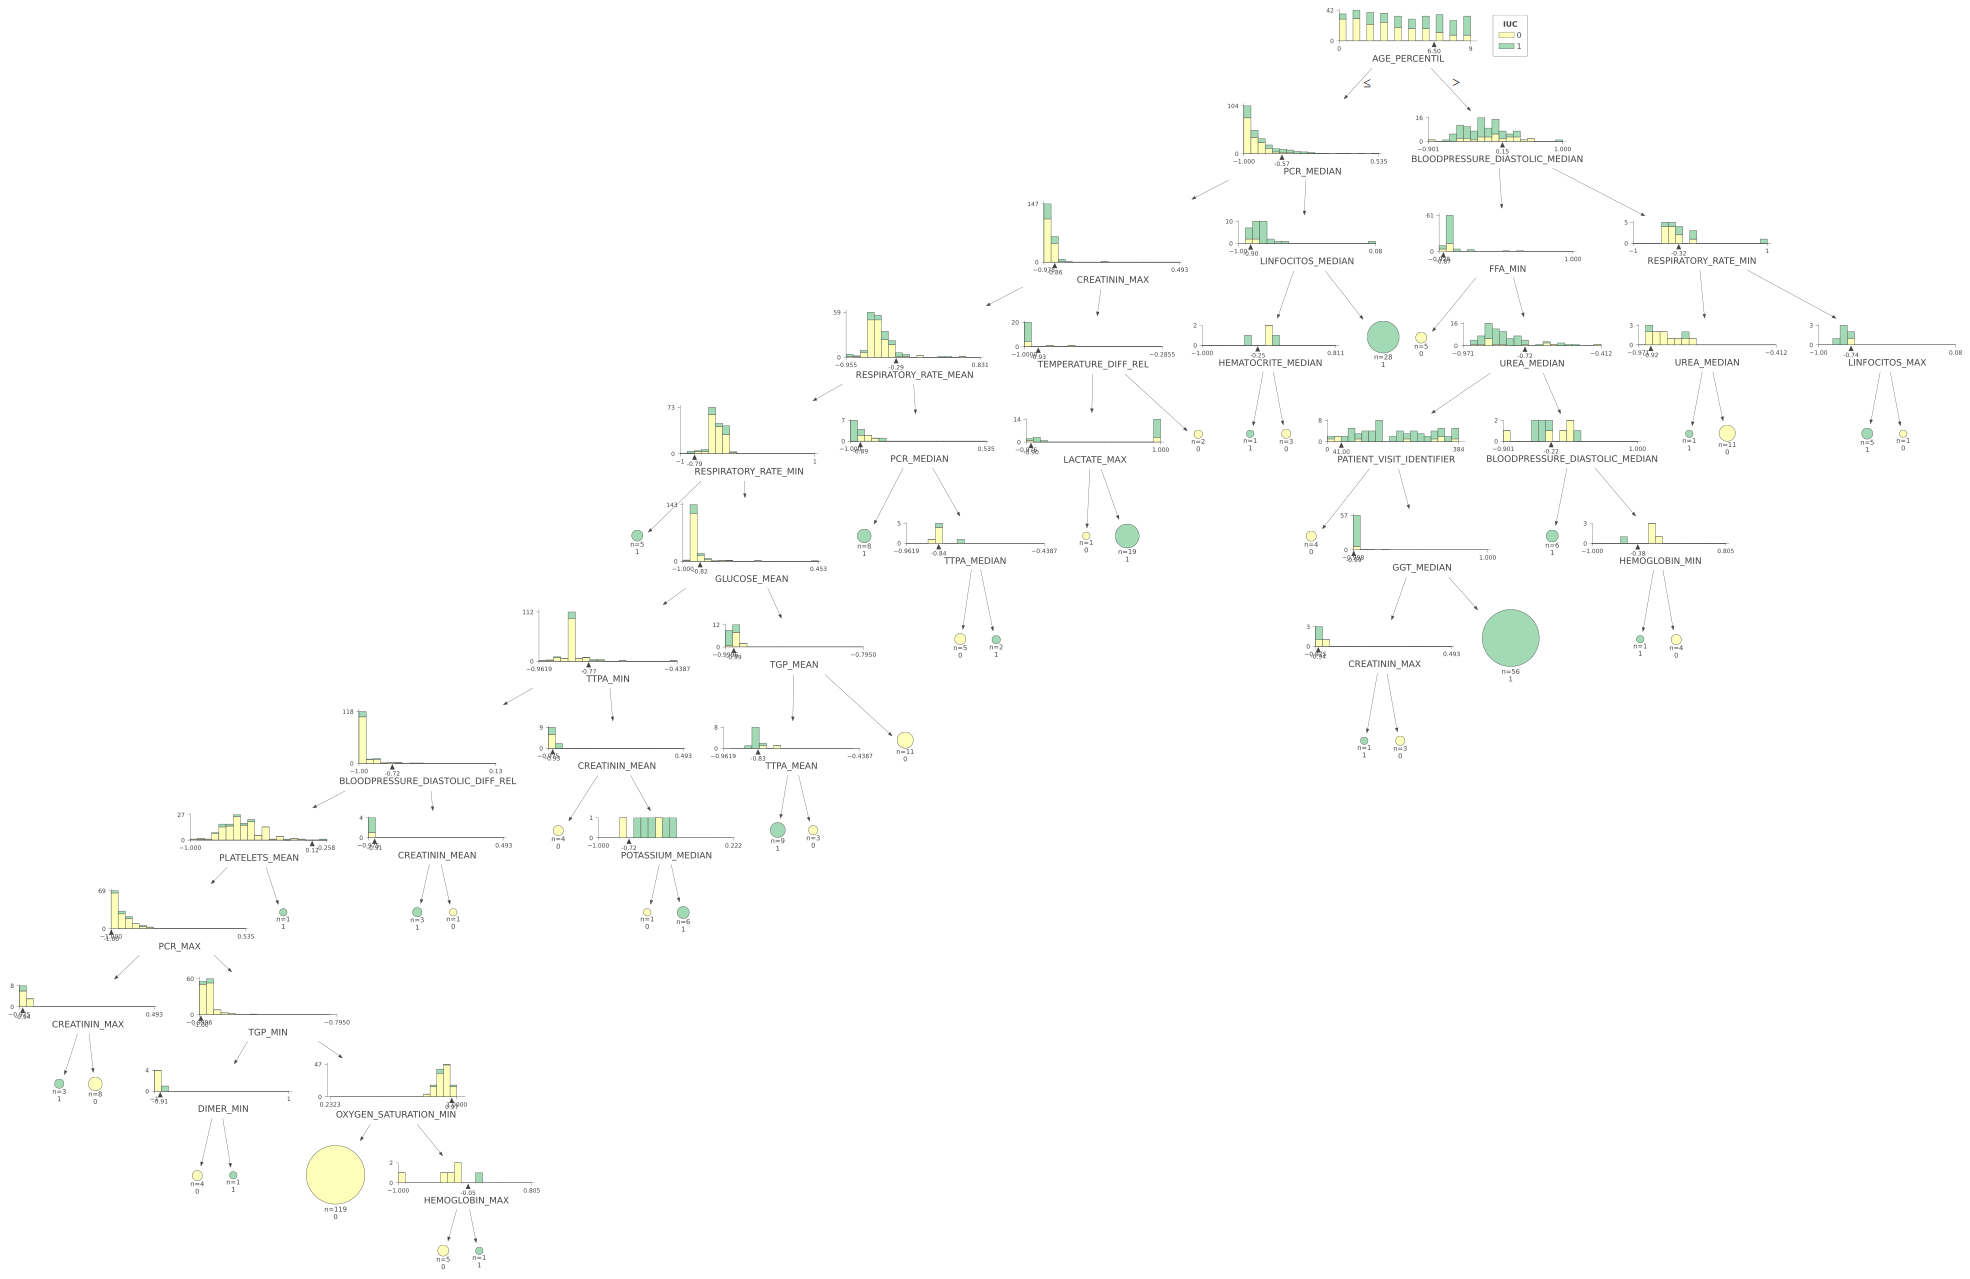

In [ ]:
from dtreeviz.trees import dtreeviz 
viz = dtreeviz(modelo_arvore, x, y,
                target_name="IUC",
                feature_names=x.columns,
                class_names=['0','1'])

viz

###**Desafio 05: Criar uma função que gere a curva ROC.** ✔️

Utilizando a lib yellowbrick: 

In [ ]:
!pip install yellowbrick #fazer a instalação

In [ ]:
from yellowbrick.classifier import ROCAUC #importar ROCAUC

In [ ]:
'''
Essa função plota o gráfico da Curva ROC
'''
def plotar_roc_auc(dados, modelo):

  #Definindo x e y
  x = dados.drop(["ICU"], axis=1)
  y = dados["ICU"]
  
  np.random.seed(727356) #para garantir a reprodutibilidade
 
  #Separando os dados em treino e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.2, stratify=y)

  #Treino
  modelo.fit(x_train, y_train) 

  #Predição
  predicao = modelo.predict(x_test)  

  #Plotando o gráfico
  fig, ax = plt.subplots(figsize=(9,9))
  roc_viz = ROCAUC(modelo)
  roc_viz.score(x_test,y_test) #scores que irão aparecer na legenda
  plt.legend()
  ax.set_ylabel("Taxa de verdadeiros positivos - TPR", fontsize=18)
  ax.set_xlabel("Taxa de falsos positivos - FPR", fontsize=18)
  plt.title(f"Curva ROC - Modelo {modelo.__class__.__name__}", fontsize=20, loc='left', weight='bold')
  plt.show()

###**Desafio 06: Pensar e tentar diminuir o efeito de aleatoriedade nas previsões.**✔️

https://machinelearningmastery.com/how-to-reduce-model-variance/

##**Aula 3**

###**Desafio 07: Estudar a documentação do sklearn e testar outros modelos.**✔️ 

* https://scikit-learn.org/stable/modules/classes.html#api-reference
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

> Vários modelos foram testados no projeto final: https://github.com/vqrca/bootcamp_alura_projeto_final

##**Aula 4**

###**Desafio 08: Testar outros splitter classes e observar as diferenças.** ✔️

* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

##**Aula 5**

###**Desafio 09: Deixar o gráfico de AUC bonitão.** ✔️



In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10,6)


#Configuração das cores utilizadas nos gráficos: 
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
PURPLE1 = 'darkorchid'

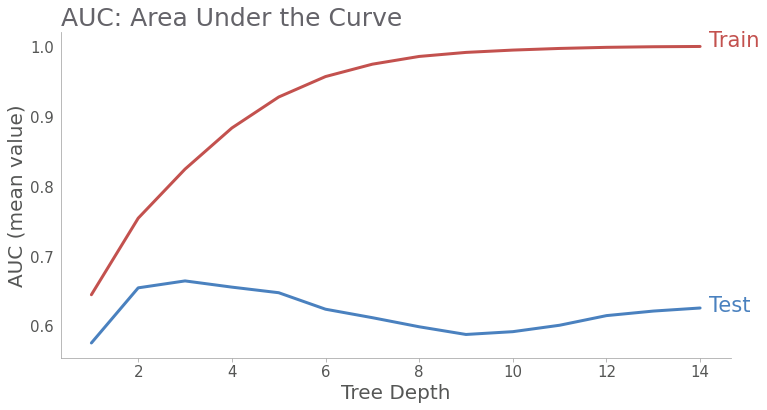

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

x = range(1,15)
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(x, teste_lista, color=BLUE2, linewidth=3) 
plt.plot(x, treino_lista, color=RED1, linewidth=3)
plt.ylabel('AUC (mean value)', fontdict = {'fontsize': 20}, color = GRAY3)
plt.xlabel('Tree Depth', fontdict = {'fontsize': 20}, color = GRAY3)
plt.title('AUC: Area Under the Curve',loc = 'left', fontsize = 25, color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.text(14.2, 1.0, 'Train', fontsize='21', color=RED1)
ax.text(14.2, 0.62, 'Test', fontsize='21', color=BLUE2)
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in ax.get_yticklabels() + ax.get_xticklabels():
  i.set_fontsize(15)
  i.set_color(GRAY3)
for i in ax.get_yticklabels() + ax.get_xticklabels():
  i.set_fontsize(15)
  i.set_color(GRAY3)
plt.show()

Em vermelho temos as médias de AUC para treino.

Em azul temos as médias de AUC para teste.

Os valores começam relativamente próximos, porém após o quinto max depth, os dados de teste começam a cair. Enquanto isso, os valores de treino começam a crescer. Quando isso ocorre temos o Overfitting: o modelo ficou tão bom em separar os dados a partir do treino, que ele não consegue generalizar os dados de teste.

###**Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic).** ✔️

* https://www.kaggle.com/c/titanic

In [26]:
URL_titanic_test = 'https://github.com/vqrca/bootcamp_alura_aulas/blob/main/Modulo_5/test.csv?raw=true'
URL_titanic_train = 'https://github.com/vqrca/bootcamp_alura_aulas/blob/main/Modulo_5/train.csv?raw=true'

In [27]:
df_titanic_train = pd.read_csv(URL_titanic_train)
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
df_titanic_train.Sex = df_titanic_train.Sex.astype("category").cat.codes
df_titanic_train.Cabin = df_titanic_train.Cabin.astype("category").cat.codes
df_titanic_train.Embarked = df_titanic_train.Embarked.astype("category").cat.codes
df_titanic_train.Age = df_titanic_train.Age.fillna(df_titanic_train.Age.mean())
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,-1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,-1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,-1,2


In [33]:
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import StratifiedKFold #para fazer o split dos dados
    from sklearn.model_selection import cross_validate

In [35]:
def roda_modelo_cv_col(modelo, dados, n_splits, n_repeats, col_y):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.describe().columns
    y = dados[col_y]
    x = dados[x_columns].drop([col_y], axis=1)
    
  
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino
    #print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [36]:
roda_modelo_cv_col(DecisionTreeClassifier(), df_titanic_train, 5, 10, 'Survived')

AUC  0.7380840615972248 - 1.0


(0.7380840615972248, 1.0)

In [37]:
from sklearn.tree import DecisionTreeClassifier

teste_lista = []
treino_lista = []
x = range(1,15)
for i in x:
    modelo_arvore = DecisionTreeClassifier(max_depth=i)
    teste, treino = roda_modelo_cv_col(modelo_arvore, df_titanic_train, 5, 10, 'Survived')
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC  0.7668882039380643 - 0.7668737460780635
AUC  0.8241636416251963 - 0.8329566431288036
AUC  0.8396729423212155 - 0.8648894743931116
AUC  0.8389744039328029 - 0.8877037554376521
AUC  0.8265037927670614 - 0.9100225340629919
AUC  0.8094391449040725 - 0.9284873561363177
AUC  0.7845092231946628 - 0.9461721700352089
AUC  0.7666864766176986 - 0.9603509517559574
AUC  0.7499419671266265 - 0.9732361229172038
AUC  0.7399780920019312 - 0.9821192333194853
AUC  0.7337934882151722 - 0.9883108890884651
AUC  0.732527082102377 - 0.9926000798039731
AUC  0.7343540967643538 - 0.9953317320838768
AUC  0.7301340899669873 - 0.9970800084861571


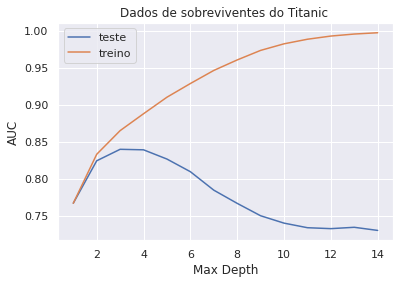

In [38]:
import seaborn as sns

sns.set()
ax = plt.subplot()
sns.lineplot(x=x, y=teste_lista, ax=ax, label='teste')
sns.lineplot(x=x, y=treino_lista, ax=ax, label='treino')
ax.set_xlabel('Max Depth')
ax.set_ylabel('AUC')
ax.set_title('Dados de sobreviventes do Titanic ')
plt.show()

###**Desafio 11: Estudar um pouco mais sobre overfit e underfit.** ✔️

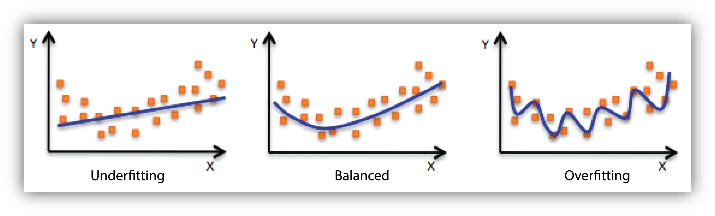

 - Overfitting (sobre-ajuste) é um termo usado em estatística para descrever quando um modelo estatístico se ajusta muito bem ao conjunto de dados anteriormente observado, mas se mostra ineficaz para prever novos resultados.


- Já o Underfitting acontece quando um modelo de aprendizado de máquina não é complexo o suficiente para capturar com precisão as relações entre os recursos de um conjunto de dados e uma variável de destino. Um modelo insuficiente resulta em resultados problemáticos ou errôneos em novos dados, ou dados nos quais não foi treinado, e muitas vezes tem um desempenho ruim, mesmo em dados de treinamento. O desempenho insatisfatório nos dados de treinamento pode ocorrer porque o modelo é muito simples (os recursos de entrada não são suficientemente expressivos) para descrever o destino. É possível melhorar o desempenho aumentando a flexibilidade do modelo.

Referência
> [Ajuste do modelo: Subajuste versus sobreajuste](https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html)
>
> [Overfitting and Underfitting](https://medium.com/@itbodhi/overfitting-and-underfitting-in-machine-learning-models-76cb60dbdaf6)
>
> [Underfitting and Overfitting in Machine Learning](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)
> 
>[IBM - Underfitting](https://www.ibm.com/cloud/learn/underfitting)




###**Desafio 12: Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros.** ✔️

Mesmo após comparar dois algoritmos e escolher qual é o melhor, ainda existe espaço para explorar os algoritmos e encontrar o melhor modelo, faremos isso através dos hiperparâmetros.

Os hiperparâmetros são características do seu modelo que podem ser definidas através dos parâmetros, por exemplo o `DecisionTreeClassifier` conta com parâmetros `max_depth` e `min_samples_split` que dependendo do valor vão te entregar um modelo melhor adaptado aos seus dados.

> Hiperparâmetros foram testados no projeto final: https://github.com/vqrca/bootcamp_alura_projeto_final

###**Desafio 13: Pesquisar como salvar um modelo treinado.** ✔️

Depois de treinado seu modelo pode ser salvo, e com isso poderá utilizar ele em outro projeto, por exemplo um projeto web. Existem diversos caminhos para isso, como pode ver na [documentação](https://scikit-learn.org/stable/modules/model_persistence.html).



**Usando a biblioteca [joblib](https://joblib.readthedocs.io/en/latest/)**


In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)

from joblib import dump, load
dump(modelo_arvore, 'filename.joblib') 

['filename.joblib']

Utilizamos a função `dump`, colocamos o primeiro parâmetro com a variável que contem nosso modelo treinado, no caso a `modelo_arvore` e depois o nome do arquivo que será gerado e guardará nosso modelo.

E quando estiver em um novo projeto e quiser usar aquele modelo já treinado poderá usar a função `load`:



In [ ]:
modelo_arvore = load('filename.joblib')

**Usando o pickle**

O pickle permite a serialização de objetos, ou seja, os transforma em sequências de bytes. Armazenando toda informação necessária, consegue reconstruir objetos aplicando uma lógica interna.


In [ ]:
import pickle

from sklearn import datasets
from sklearn.ensemble import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)

with open('model.pkl', 'wb') as model_file:
  pickle.dump(modelo_arvore, model_file)

Referência:
> [Como exportar modelos para previsão](https://cloud.google.com/ai-platform/prediction/docs/exporting-for-prediction?hl=pt-BR#joblib_1)

##**Aula 6**

###**Desafio 14: Ler no Sklearn sobre feature selection, feature importance.** ✔️

https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html



###**Desafio 15: Plotar também a matriz de confusão.** ✔️

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) #para garantir a reprodutibilidade
    dados = dados.sample(frac=1).reset_index(drop=True) #dados.sample(frac=1): embaralhamento dos dados
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score']) #media do AUC - teste
    auc_medio_treino = np.mean(resultados['train_score']) #media do AUC - treino

    auc_std = np.std(resultados['test_score']) #desvio-padrão do teste
    
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [ ]:
roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC  0.8042220502500108 - 1.0


(0.8042220502500108, 1.0)

In [ ]:
modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.5909090909090909

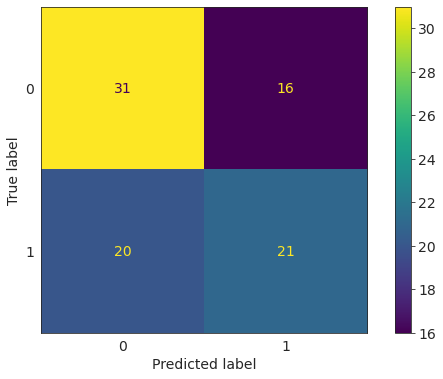

In [ ]:
plot_confusion_matrix(modelo_arvore, x_test, y_test)

###**Desafio 16: Repassar pelo desafio 12, com as bases de dados alteradas.**✔️


> Esse processo foi realizado no projeto final: https://github.com/vqrca/bootcamp_alura_projeto_final

###**Desafio Extra: Criar um pipeline de treinamento.**✔️

Encontrar o melhor o modelo vai ficando mais complexo conforme aprendemos novas etapas como normalização de dados, validação cruzada e otimização de parâmetros. Pensando em resolver essa complexidade e evitar erros nesses processos, vamos conhecer um recurso do scikit-learn: os *pipelines* e o que eles nos permitem, como por exemplo fixar uma sequência linear de etapas, que são:

[Dados], [processamento de dados], [seleção de características], [normalização], [classificação].


O scikit-learn nos permite construir essa estrutura através do Pipeline e para utilizá-lo definimos a sequência de passos utilizando uma lista que é composta de tuplas e essa por sua vez, terá o nome da etapa e a classe:

```
# pipeline = Pipeline([('cat_selector', RemoveCorrVar()),
                     ('Modelo', modelo)])
```







 

Quando o cross_validation separa nossos dados em teste e treino, a ideia é que a nossa função leia os dados de treino, identifique as colunas com alta correlação e as remova tanto dos dados de treino quanto dos dados de teste.

Para criarmos essa solução precisamos criar uma classe, que será chamada RemoveCorrVar e nela vamos construir nossa estratégia.

Para o Pipeline aceitar nossa classe precisamos colocar entre parênteses (BaseEstimator, TransformerMixin) que são outras classes que o pipeline requisita.

Vamos também criar esse __init__ e nele definir o `valor_corte`, que é o valor de correlação máxima que vamos manter.

A parte de encontrar as colunas com alta correlação vai ficar dentro do fit que por padrão vai receber os nossos dados X e Y.

In [ ]:
class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte

    def fit( self, X, y = None ):
        matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 

Não retiramos as colunas ainda, apenas salvamos elas na variável `self.excluir` . O motivo disso é que temos um trecho específico para isso, ele é chamado de transform, o drop vai ficar nesse trecho para que ele seja aplicado tanto nos dados de treino, quanto nos de teste.

In [ ]:
class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte

    def fit( self, X, y = None ):
        matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 

    def transform(self, X, y = None):
        X = X.drop(self.excluir, axis=1)
        return X

Com a etapa pronta, podemos incluí-la no Pipeline, pelo nome `cat_selector`, seletor de características. Finalmente podemos utilizar agora o pipeline no lugar do modelo dentro da função `roda_modelo_cv` criada na aula.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

def roda_modelo_cv_pipeline(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    pipeline = Pipeline([('cat_selector', RemoveCorrVar()),
                         ('Modelo', modelo)])    

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(pipeline, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])

    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino

Então agora cada vez que nosso modelo for treinado no `cross_validate` antes ele vai remover as colunas que julgamos desnecessárias.

Pesquisar: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler